# Implementing Partial Convolution
----
Based on: https://github.com/MathiasGruber/PConv-Keras/blob/master/notebooks/Step2%20-%20Partial%20Convolution%20Layer.ipynb

Converted into pytorch from keras

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
from PIL import Image
from torchvision import transforms
import numpy as np

In [2]:
import sys
sys.path.append('..')
from utils import MaskGenerator
from blocks import PartialConv2d

## Testing

### Load data

In [3]:
# Torchvision transform
T = transforms.Compose([
    transforms.CenterCrop(150),
    transforms.ToTensor()
])

# Load image
img = T(Image.open(r'/mnt/data/data/celeba/img_align_celeba/090055.jpg')).to('cuda')
print(f"Image tensor size: {img.size() , img.dtype}")

# Generate mask
img_mask = MaskGenerator(150, 150).sample(5).type_as(img)
print(f"Mask tensor size: {img_mask.size(), img_mask.dtype}")

# Image + mask
masked_img = img * img_mask
print(f"Masked image size: {masked_img.size(), masked_img.dtype}")

Image tensor size: (torch.Size([3, 150, 150]), torch.float32)
Mask tensor size: (torch.Size([150, 150]), torch.float32)
Masked image size: (torch.Size([3, 150, 150]), torch.float32)


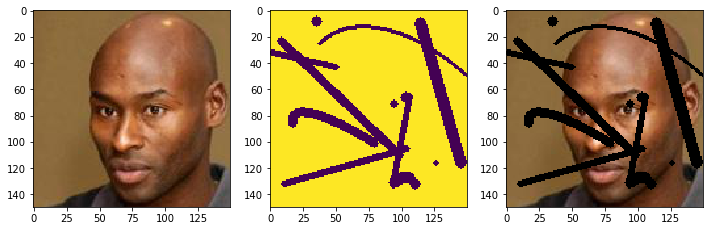

In [4]:
_, axes = plt.subplots(1,3, figsize=(12,4))

axes[0].imshow(img.permute(1,2,0).cpu().numpy())
axes[1].imshow(img_mask.cpu().numpy() * 255)
axes[2].imshow(masked_img.permute(1,2,0).cpu().numpy())

## Test the partial convolution layers

Just a several layers of partial_conv2d, while saving all the outputs for the validation of the layer.

In [5]:
pc1 = PartialConv2d(3, 8, kernel_size=(5, 5), stride=(2,2)).to('cuda')

image_in = img.expand(1,-1,-1,-1)
mask_in = img_mask.type_as(img).expand(1,3,-1,-1)

out_img1 = pc1((image_in, mask_in))

print(f'Output image shape = {out_img1.shape}')
print(f'Output image mask = {pc1.mask_out.shape}')

Output image shape = torch.Size([1, 8, 75, 75])
Output image mask = torch.Size([1, 8, 75, 75])


In [6]:
pc2 = PartialConv2d(8, 16, kernel_size=(3,3), stride=(2,2)).to('cuda')
out_img2 = pc2((out_img1, pc1.mask_out))

print(f'Output image shape = {out_img2.shape}')
print(f'Output image mask = {pc2.mask_out.shape}')

Output image shape = torch.Size([1, 16, 38, 38])
Output image mask = torch.Size([1, 16, 38, 38])


In [7]:
pc3 = PartialConv2d(16, 32, kernel_size=(3,3), stride=(2,2)).to('cuda')
out_img3 = pc3((out_img2, pc2.mask_out))

print(f'Output image shape = {out_img3.shape}')
print(f'Output image mask = {pc3.mask_out.shape}')

Output image shape = torch.Size([1, 32, 19, 19])
Output image mask = torch.Size([1, 32, 19, 19])


### Let's check the mask outputs

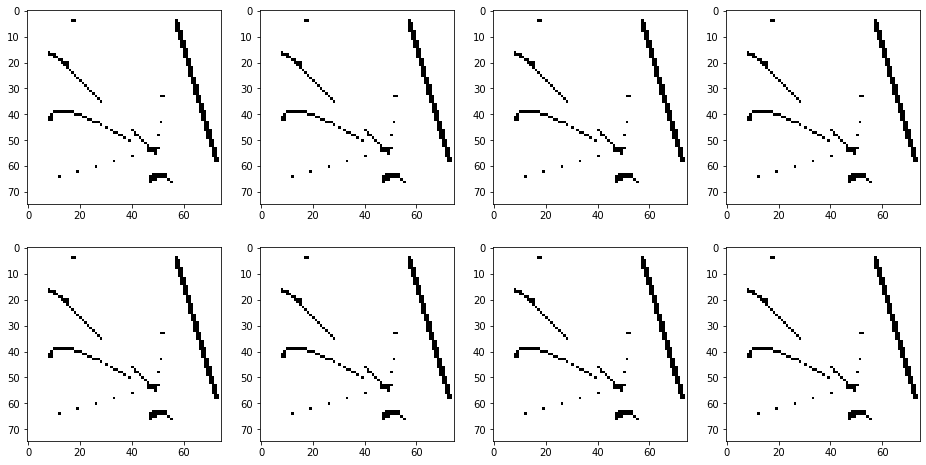

In [8]:
fig = plt.figure(figsize=(16, 8))
M = pc1.mask_out.cpu().numpy()
for i in range(8):
    ax = fig.add_subplot(2, 4, i+1)
    ax.imshow(M[0, i, :, :], cmap=plt.cm.gray, vmin=0, vmax=1)

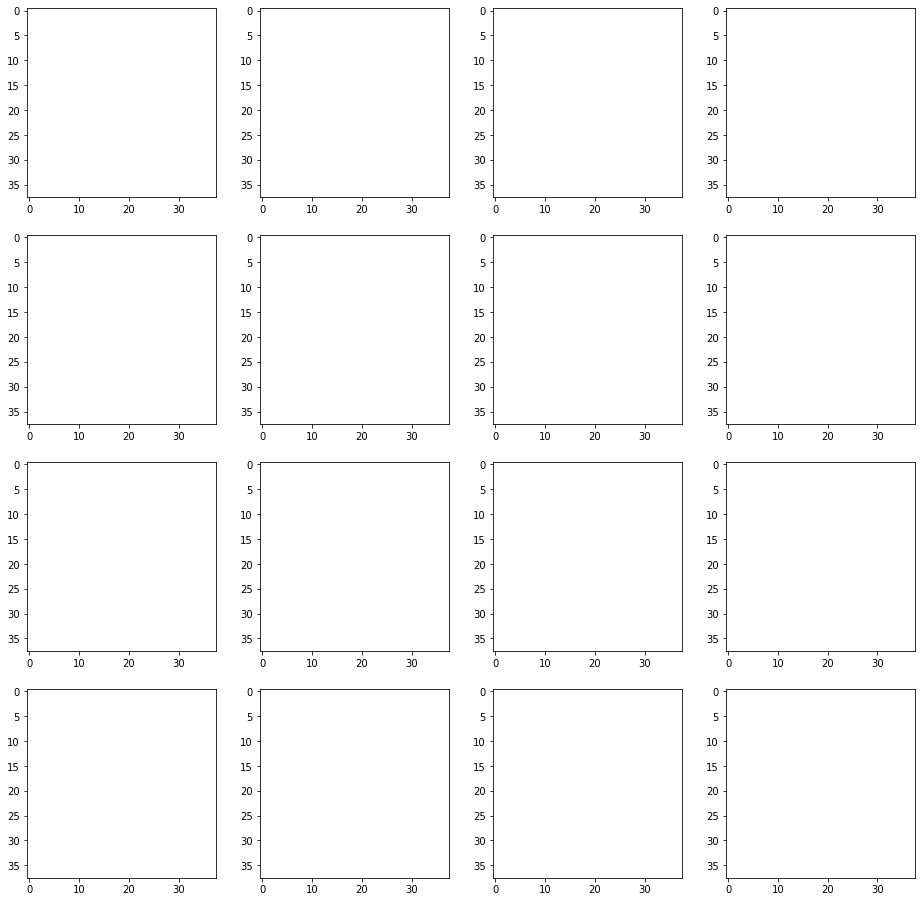

In [9]:
fig = plt.figure(figsize=(16, 16))
M = pc2.mask_out.cpu().numpy()
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(M[0, i, :, :], cmap=plt.cm.gray, vmin=0, vmax=1)